In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  
from torchvision import models
from torch import optim
%matplotlib inline

In [2]:
data_dir = "../input/New Plant Diseases Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [3]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
batch_size = 128
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [5]:
model = models.vgg16(pretrained=True)

In [6]:
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(25088, 4096),
                          nn.Dropout(p = 0.5),
                          nn.BatchNorm1d(num_features=4096),
                          nn.ReLU(),
                          nn.Linear(4096, 1024),
                          nn.Dropout(p = 0.5),
                          nn.BatchNorm1d(num_features=1024),
                          nn.ReLU(),
                          nn.Linear(1024, 38))
    
model.classifier = classifier

In [7]:
learning_rate = 0.0001
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [8]:
criterion = nn.CrossEntropyLoss()
# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [9]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
total_step = len(train_dl)
total_step = len(train_dl)
num_epoch = 8
List_acc_valid=[]
List_acc_train=[]  
List_loss_valid=[]
List_loss_train=[]
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 275 == 274:    # print every 1000 mini-batches
            correct_train = 0
            total_train = 0
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            acc_train = 100 * correct_train/total_train
            running_loss = 0.0
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {}%, Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, acc_train, loss.item()))
    
    correct = 0
    total = 0
    model.eval()
    total_loss_per_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dl):
            images_valid, labels_valid = data[0].to(device), data[1].to(device)
            outputs_valid = model(images_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            total_loss_per_epoch += loss_valid.item()
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels_valid.size(0)
            correct += (predicted == labels_valid).sum().item()
            acc_valid = 100 * correct / total
        loss_per_epoch = total_loss_per_epoch/i    
        print('Accuracy: %.2f %%' % (100 * correct / total))
        print(loss_per_epoch)
        
        List_acc_valid.append(acc_valid)
        List_acc_train.append(acc_train)
        List_loss_valid.append(loss_valid.item())
        List_loss_train.append(loss.item()) 
print('Finished Training of VGG-16')

C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/8], Step [275/550], Accuracy: 96.875%, Loss: 0.2475
Epoch [1/8], Step [550/550], Accuracy: 100.0%, Loss: 0.1864
Accuracy: 97.02 %
0.25311902709250905
Epoch [2/8], Step [275/550], Accuracy: 100.0%, Loss: 0.0472
Epoch [2/8], Step [550/550], Accuracy: 95.83333333333333%, Loss: 0.1958
Accuracy: 97.27 %
0.159847836846309
Epoch [3/8], Step [275/550], Accuracy: 100.0%, Loss: 0.0160
Epoch [3/8], Step [550/550], Accuracy: 100.0%, Loss: 0.0435
Accuracy: 97.97 %
0.10143572538003434
Epoch [4/8], Step [275/550], Accuracy: 100.0%, Loss: 0.0087
Epoch [4/8], Step [550/550], Accuracy: 100.0%, Loss: 0.0227
Accuracy: 97.87 %
0.08790986349697422
Epoch [5/8], Step [275/550], Accuracy: 100.0%, Loss: 0.0045
Epoch [5/8], Step [550/550], Accuracy: 100.0%, Loss: 0.0098
Accuracy: 97.91 %
0.0871036651231566
Epoch [6/8], Step [275/550], Accuracy: 100.0%, Loss: 0.0043
Epoch [6/8], Step [550/550], Accuracy: 100.0%, Loss: 0.0070
Accuracy: 97.66 %
0.09590503473487431
Epoch [7/8], Step [275/550], Accuracy: 99.

In [11]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
classes = ('Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus')

 Accuracy for train dataset:100.00%
 Accuracy for valid dataset:97.60%




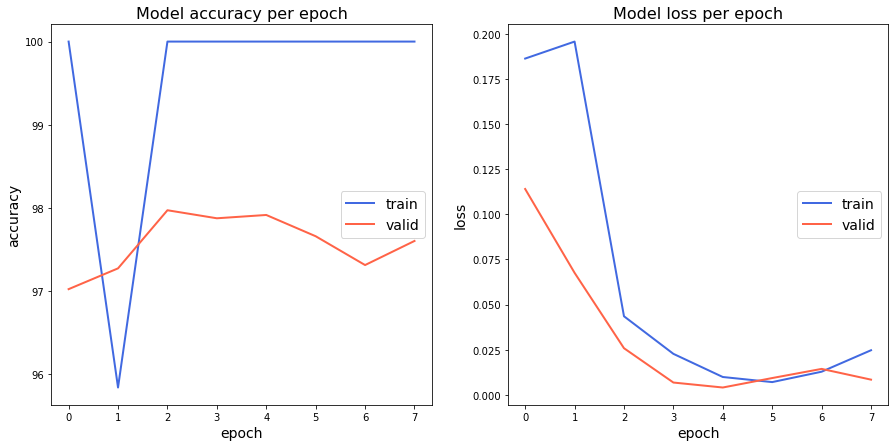

In [12]:
#Train and Valid Accuracy & Loss curve
#-------------------------------------------------------------------------------
print('\033[1m Accuracy for train dataset:{:.2f}%\033[0m'.format(List_acc_train[-1]))
print('\033[1m Accuracy for valid dataset:{:.2f}%\033[0m'.format(List_acc_valid[-1]))
print('\n')

#Accuracy curves
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(List_acc_train,"royalblue",linewidth=2)
plt.plot(List_acc_valid,"tomato",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(List_loss_train,"royalblue",linewidth=2)
plt.plot(List_loss_valid,"tomato",linewidth=2)
plt.title('Model loss per epoch',fontsize=16)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)
plt.show()

In [14]:
PATH = './plant38_VGG16_full.pth'
torch.save(model, PATH)

In [15]:
class_correct = list(0. for i in range(38))
class_total = list(0. for i in range(38))
model.eval()
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(36):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(38):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Apple___Apple_scab : 100 %
Accuracy of Apple___Black_rot : 100 %
Accuracy of Apple___Cedar_apple_rust : 100 %
Accuracy of Apple___healthy : 99 %
Accuracy of Blueberry___healthy : 100 %
Accuracy of Cherry_(including_sour)___healthy : 99 %
Accuracy of Cherry_(including_sour)___Powdery_mildew : 100 %
Accuracy of Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 89 %
Accuracy of Corn_(maize)___Common_rust_ : 100 %
Accuracy of Corn_(maize)___healthy : 93 %
Accuracy of Corn_(maize)___Northern_Leaf_Blight : 100 %
Accuracy of Grape___Black_rot : 97 %
Accuracy of Grape___Esca_(Black_Measles) : 100 %
Accuracy of Grape___healthy : 99 %
Accuracy of Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 99 %
Accuracy of Orange___Haunglongbing_(Citrus_greening) : 98 %
Accuracy of Peach___Bacterial_spot : 98 %
Accuracy of Peach___healthy : 100 %
Accuracy of Pepper,_bell___Bacterial_spot : 97 %
Accuracy of Pepper,_bell___healthy : 97 %
Accuracy of Potato___Early_blight : 99 %
Accuracy of Potato__